In [1]:
import sys
import traceback
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import u3

In [13]:
class robotVer2:
    
    def __init__(self):
        self.labjack = u3.U3()
        self.__resistance = 500
        
    def close(self):
        self.labjack.close()
                            
    def printAnalogIns(self):
        AIN0value = self.labjack.getAIN(0)
        AIN1value = self.labjack.getAIN(1)
        descriptor ='A0 = %5.3f volts, A1 = %5.3f volts ' % (AIN0value, AIN1value)
        print(descriptor)

    def setDAC0(self,voltage = 0):
        if voltage < 0:
            print('output voltage must be >= 0')
            return
        elif voltage > 5:
            print('output voltage must be <= 5')
            return
        else:
            DAC0_VALUE = self.labjack.voltageToDACBits(voltage, dacNumber = 0, is16Bits = False)
            self.labjack.getFeedback(u3.DAC0_8(DAC0_VALUE))

    
    def configLabJack(self, theDivisor = 16):
        self.labjack.configIO(NumberOfTimersEnabled = 2, FIOAnalog=3)
        self.labjack.configTimerClock(TimerClockBase = 6, TimerClockDivisor=theDivisor)

    def setPWM(self, highFraction = 1, whichTimer = 0):
        if highFraction>1 or highFraction<0:
            print('highFraction should be a real number between 0 and 1.')
            return
        i = int((1-highFraction)*65535)
        if whichTimer == 0:
            self.labjack.getFeedback(u3.Timer0Config(TimerMode = 0, Value = i))
        elif whichTimer == 1:
            self.labjack.getFeedback(u3.Timer1Config(TimerMode = 0, Value = i))
        else:
            print('There are two timers only! Please input 0 or 1.')
            return

    def plotTwoChannels(self):
        MAX_REQUESTS = 25
        SCAN_FREQUENCY = 5000
        self.labjack.streamConfig(NumChannels=2, PChannels=[0, 1], NChannels=[31, 31], Resolution=3, ScanFrequency=SCAN_FREQUENCY)
        
        print("Start stream")
        try:
            self.labjack.streamStart()
        except:
            print("Stopping existing stream..")
            self.labjack.streamStop()
            time.sleep(0.1)
            self.labjack.streamStart()

        start = datetime.now()
        print("Start time is %s" % start)

        missed = 0
        dataCount = 0
        packetCount = 0

        allSamples0 = np.array([])
        allSamples1 = np.array([])
        for r in self.labjack.streamData():
            if r is not None:
                if dataCount >= MAX_REQUESTS:
                    break
                allSamples0 = np.concatenate((allSamples0,r['AIN0']))
                allSamples1 = np.concatenate((allSamples1,r['AIN1']))
                dataCount += 1
            else:
                print("No data ; %s" % datetime.now())

        stop = datetime.now()
        seconds=np.linspace(0,(stop-start).total_seconds(),15000)
        self.labjack.streamStop()
        print("Stream stopped.\n")
        self.labjack.close()
        
        plt.figure()
        plt.subplot(211)
        plt.xlabel('Time (s)')
        plt.ylabel('AIN0 (V)')
        plt.plot(seconds,allSamples0, 'b-', label='AIN0')
        plt.subplot(212)
        plt.xlabel('Time (s)')
        plt.ylabel('AIN1 (V)')
        plt.plot(seconds,allSamples1, 'b-', label='AIN1')
        plt.show()

    def getChannel(self, whichChannel = "AIN0" ):
        MAX_REQUESTS = 5
        SCAN_FREQUENCY = 5000
        self.labjack.streamConfig(NumChannels=2, PChannels=[0, 1], NChannels=[31, 31], Resolution=3, ScanFrequency=SCAN_FREQUENCY)
        
        print("Start stream")
        try:
            self.labjack.streamStart()
        except:
            print("Stopping existing stream..")
            self.labjack.streamStop()
            time.sleep(0.1)
            self.labjack.streamStart()

        start = datetime.now()
        print("Start time is %s" % start)

        missed = 0
        dataCount = 0
        packetCount = 0

        allSamples = np.array([])
        for r in self.labjack.streamData():
            if r is not None:
                if dataCount >= MAX_REQUESTS:
                    break
                allSamples = np.concatenate((allSamples,r[whichChannel]))
                dataCount += 1
            else:
                print("No data ; %s" % datetime.now())

        stop = datetime.now()
        seconds=np.linspace(0,(stop-start).total_seconds(),3000)
        self.labjack.streamStop()
        print("Stream stopped.\n")
        self.labjack.close()
        return seconds, allSamples

    def plotChannel(self, whichChannel = "AIN0" ):
        times,allSamples = self.getChannel(whichChannel)
        plt.figure()
        plt.plot(times,allSamples, 'b-', label=whichChannel)
        plt.xlabel('time, seconds')
        plt.ylabel('voltage on %s' % whichChannel)

In [17]:
rb0=robotVer2()
rb0.configLabJack(96)
rb0.setDAC0(0)

In [18]:
#rb0.setPWM(0.5,1)
rb0.setPWM(0.5,0)

Start stream
Start time is 2020-11-29 15:24:53.674044
Stream stopped.



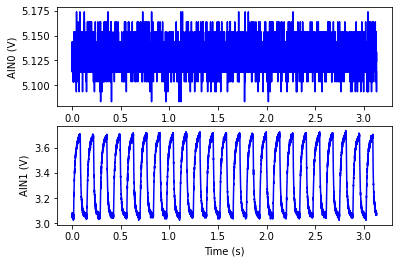

In [19]:
rb0.plotTwoChannels()

In [20]:
rb0.close()

f_c=1/(2pi RC)
R = 500 ohm
C_1=10 uF  
C_2=0.1 uF

In [1008]:
#rb0.gtChannel()

In [335]:
#rb0.plotChannel('AIN1')

In [339]:
def helloPWM(theBase=4, theDivisor=15):
    d = u3.U3() # Opens first found U3 over USB
    d.configIO(NumberOfTimersEnabled = 2,FIOAnalog=3)
    #FIOAnalog=3 meaning 
    #Each bit determines whether that bit of FIO is analog input (=1) or digital I/O (=0).
    d.configTimerClock(TimerClockBase = theBase, TimerClockDivisor = theDivisor)#original 6,15

    print("This example allows the LabJack U3 conrol two analog servos using PWM.")
    print("The control signals will come out of the FIO4 and FIO5 screw terminals.")
    print("The PWM control number can be from 0 to 65535.")
    print("Enter numbers to control the PWM width, which will cause the servo motor to move.")
    print("(Exactly what the motor does depends on the type of motor.)")
    print("Entering 0 will cause the PWM output to be high 100% of the time.")
    print("Entering 32768 will cause the PWM output to be high 50% of the time.")
    print("Entering 65535 will cause the PWM output to be high almost 0% of the time.")
    print("Entering -1 will stop the program")
    i=0
    while (i>-1):

         d.getFeedback(u3.Timer0Config(TimerMode = 0, Value = i))
         d.getFeedback(u3.Timer1Config(TimerMode = 0, Value = i))
         i = int(input('Choose a number: '))

In [342]:
helloPWM(6,160)

This example allows the LabJack U3 conrol two analog servos using PWM.
The control signals will come out of the FIO4 and FIO5 screw terminals.
The PWM control number can be from 0 to 65535.
Enter numbers to control the PWM width, which will cause the servo motor to move.
(Exactly what the motor does depends on the type of motor.)
Entering 0 will cause the PWM output to be high 100% of the time.
Entering 32768 will cause the PWM output to be high 50% of the time.
Entering 65535 will cause the PWM output to be high almost 0% of the time.
Entering -1 will stop the program


Choose a number:  32786
Choose a number:  -1


In [4]:
def plotChannel(whichChannel = "AIN0" ):
    # MAX_REQUESTS is the number of packets to be read.
    MAX_REQUESTS = 5
    # SCAN_FREQUENCY is the scan frequency of stream mode in Hz
    SCAN_FREQUENCY = 5000
    
    d = u3.U3()
    # To learn the if the U3 is an HV
    
    # Set the FIO0 and FIO1 to Analog (d3 = b00000011)
    #d.configIO(FIOAnalog=3,NumberOfTimersEnabled = 2) #don't call this if you've set up PWM to do something you care about.
    #print("Configuring U3 stream")
    d.streamConfig(NumChannels=2, PChannels=[0, 1], NChannels=[31, 31], Resolution=3, ScanFrequency=SCAN_FREQUENCY)
    #d.streamStop() #this is not strictly necessary but makes things more robust; without it it crashes if a steam has already been started
   
    print("Start stream")
    try:
        d.streamStart()
    except:
        print("Stopping existing stream..")
        d.streamStop()
        time.sleep(0.1)
        d.streamStart()
        
    start = datetime.now()
    print("Start time is %s" % start)

    missed = 0
    dataCount = 0
    packetCount = 0

    allSamples = np.array([])
    for r in d.streamData():
        if r is not None:
            # Our stop condition
            if dataCount >= MAX_REQUESTS:
                break

            # Comment out these prints and do something with r
            print("Average of %s AIN0, %s AIN1 readings: %s, %s" %
                  (len(r["AIN0"]), len(r["AIN1"]), sum(r["AIN0"])/len(r["AIN0"]), sum(r["AIN1"])/len(r["AIN1"])))
            allSamples = np.concatenate((allSamples,r[whichChannel]))
            dataCount += 1
            #packetCount += r['numPackets']
        else:
            # Got no data back from our read.
            # This only happens if your stream isn't faster than the USB read
            # timeout, ~1 sec.
            print("No data ; %s" % datetime.now())
        
    stop = datetime.now()
    seconds=np.linspace(0,(stop-start).total_seconds(),3000)
    d.streamStop()
    print("Stream stopped.\n")
    d.close()
    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.plot(seconds,allSamples, 'b-', label=whichChannel)
    plt.show()

In [348]:
helloPWM(6,16)

This example allows the LabJack U3 conrol two analog servos using PWM.
The control signals will come out of the FIO4 and FIO5 screw terminals.
The PWM control number can be from 0 to 65535.
Enter numbers to control the PWM width, which will cause the servo motor to move.
(Exactly what the motor does depends on the type of motor.)
Entering 0 will cause the PWM output to be high 100% of the time.
Entering 32768 will cause the PWM output to be high 50% of the time.
Entering 65535 will cause the PWM output to be high almost 0% of the time.
Entering -1 will stop the program


Choose a number:  32786
Choose a number:  -1


Start stream
Start time is 2020-11-14 15:11:40.008487
Average of 600 AIN0, 600 AIN1 readings: 1.0375770666666704, 1.4740956800000118
Average of 600 AIN0, 600 AIN1 readings: 0.9423387733333332, 1.4740621866666763
Average of 600 AIN0, 600 AIN1 readings: 1.0315817600000023, 1.4745310933333433
Average of 600 AIN0, 600 AIN1 readings: 0.9507623466666681, 1.4742464000000106
Average of 600 AIN0, 600 AIN1 readings: 1.0285841066666703, 1.4744473600000112
Stream stopped.



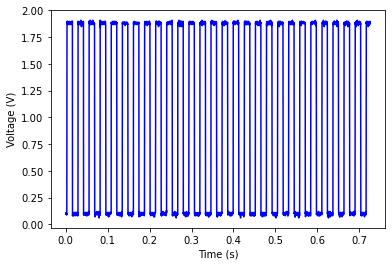

In [349]:
plotChannel("AIN0")

In [6]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])